# 추천 시스템의 기초

사용자(user)가 상품(item)에 대해 어떻게 평가하는지를 예측하는 예측 시스템

## Surprise 패키지

* https://github.com/NicolasHug/Surprise
* http://surprise.readthedocs.io/en/latest/index.html


* Koren2010: "Factor in the Neighbors: Scalable and Accurate Collaborative Filtering", YEHUDA KOREN. 2010
    - http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf
* Koren2011: "Collaborative Filtering on Ordinal User Feedback", Yehuda Koren and Joseph Sill, 2011
    - http://www.ijcai.org/Proceedings/13/Papers/449.pdf
    

!pip install --upgrade pip

!pip install --timeout 1000 surprise

In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import surprise

## 평점 데이터  

In [2]:
# MovieLense 데이터 중 10만개의 샘플 데이터세트

data = surprise.Dataset.load_builtin('ml-100k')

In [3]:
df=pd.DataFrame(data.raw_ratings, columns=['user', 'item', 'rate', 'id'])
del df['id']
df.head(10)

,user,item,rate
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0
5,298,474,4.0
6,115,265,2.0
7,253,465,5.0
8,305,451,3.0
9,6,86,3.0


>추천 시스템은 사용자 아이디와 상품 아이디라는 두 개의 카테고리 입력과 평점 출력을 가지는 예측 시스템

In [4]:
# x 상품, y 사용자 아이디 -> 평점 행렬 R (특정 사용자y 의 특정 상품x 의 평점)
df_table=df.set_index(['user', 'item']).unstack()
df_table.fillna('').iloc[212:222, 808:817]

rate                                
item  211 212 213 214 215 216 217 218 219
user                                     
290     3                   4       2    
291         4       4   4           4   4
292                 3                    
293     4       3       4   4   3   2    
294                                      
295             5       5   5   4   5    
296     4                                
297     4       3       2   4       3    
298     5       3       5                
299     4   4   5           5

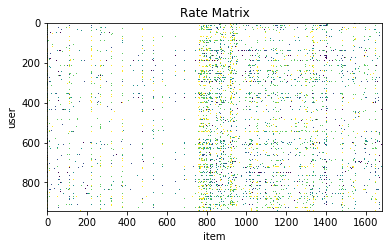

In [5]:
# 빈칸을 힌색, 점수에 색을줌 
plt.imshow(df_table)
plt.grid(False)
plt.xlabel("item")
plt.ylabel("user")
plt.title("Rate Matrix")
plt.show()

## 추천 시스템 알고리즘

1. 베이스라인 모형
2. Collaborative Filtering
    * 2-1. Neighborhood Models
        - User-based CF
        - Item-based CF
    * 2-2. Latent Factor Models
        - Matrix Factorization
        - SVD
3. Content-Based Recommendation


### 베이스라인 모형

사용자 아이디  u , 상품 아이디  i, 두 개의 카테고리 값 입력에서 평점  $r_{ui}$ 의 예측치  $\hat{r}_{ui}$  을 예측하는 가장 단순한 모형

사용자와 상품 특성에 의한 평균 평점의 합을 이용<br>
오차 함수를 최소화 하도록 구해짐 <br>
과최적화를 피하기 위해 정규화 항을 추가 할 수 있다. 

### 최적화 알고리즘 

오차 함수를 최소화하기위한 알고리즘 ( 알고리즘의 선택은 method 인수를 사용)

* ALS (Alternating Least Squares)의 인수
    reg_i: 상품에 대한 정규화 가중치. 디폴트는 10.
    reg_u: 사용자에 대한 정규화 가중치. 디폴트는 15.
    n_epochs: 최적화 반복 횟수. 디폴트는 10.
* SGD (Stochastic Gradient Descent)의 인수
    reg: 정규화 가중치. 디폴트는 0.02.
    learning_rate: 최적화 스텝 사이즈. 디폴트는 0.005.
    n_epochs: 최적화 반복 횟수. 디폴트는 20

### 모형 사용법
1. 데이터세트의 split, folds 메소드를 사용하여 K-Fold 트레이닝 데이터셋과 테스트 데이터셋을 만든다.
2. 모형 알고리즘 객체를 생성한다.
3. 모형 알고리즘 객체의 train 메서드와 트레이닝 데이터셋으로 모수를 추정한 후, test 메서드로 테스트 데이터셋에 대한 예측을 실시한다.
4. accuracy 서브패키지의 성능평가 함수를 사용하여 예측 성능을 계산한다.

evaluate 명령으로 단축할 수도 있다.

베이스라인 모형을 위한 BaselineOnly 클래스

In [6]:
data.split(n_folds=3) # 3개의 fold 로 나눔 
bsl_options = {'method': 'als',
              'n_epochs':5,
              'reg_u': 12, 
              'reg_i':5}
algo = surprise.BaselineOnly(bsl_options=bsl_options)

np.random.seed(0)
acc = np.zeros(3)
for i, (trainset, testset) in enumerate(data.folds()):
#     if i==0 : 
#         print(trainset.all_items)
#         print('-----',trainset)
#         print('-----',testset)
        
    algo.train(trainset)
    predictions = algo.test(testset)
    acc[i] = surprise.accuracy.fcp(predictions, verbose=True)
acc.mean()

Estimating biases using als...
FCP:  0.7047
Estimating biases using als...
FCP:  0.6995
Estimating biases using als...
FCP:  0.7031


0.70241740660712315

 FCP(Fraction of Concordant Pairs)로 계산한 평가 점수는 약 0.70점이다.

### 추천성능 평가기준

accuracy 서브패키지 이용 
    - RMSE(Root Mean Squared Error)
        $\text{RMSE} = \sqrt{\frac{1}{|\hat{R}|} \sum_{\hat{r}_{ui} \in \hat{R}}(r_{ui} - \hat{r}_{ui})^2}$
        
* FCP (Fraction of Concordant Pairs) :  Karen2011 에서 제안된 것으로 평점 자체가 아닌 평점에 의한 순위를 기준으로 하는 방법

evaluate 명령을 사용하면 위 코드를 다음과 같이 짧게 만들면서 여러가지 평가기준을 사용할 수 있다.

In [7]:
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm BaselineOnly.

------------
Fold 1
Estimating biases using als...
RMSE: 0.9402
MAE:  0.7441
------------
Fold 2
Estimating biases using als...
RMSE: 0.9501
MAE:  0.7533
------------
Fold 3
Estimating biases using als...
RMSE: 0.9439
MAE:  0.7482
------------
------------
Mean RMSE: 0.9447
Mean MAE : 0.7485
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.74408670479351391,
                             0.75330700924027127,
                             0.74822722434354882],
                            'rmse': [0.94022930496712953,
                             0.95007389942101372,
                             0.94389227907434359]})

## Collaborative Filter
모든 사용자의 데이터를 균일하게 사용하는 것이 아니라 평점 행렬이 가진 특정한 패턴을 찾아서 이를 평점 예측에 사용하는 방법

* CF 방법 
    -  Neighborhood 모형: 사용자나 상품 기준으로 평점의 유사성을 확인
    -  Latent Factor 모형: 행렬의 수치적 특징을 이용

## Neighborhood 모형 (Memory-based CF)

해당 사용자와 유사한(similar) 사용자에 대해 가중치를 준다. 

* 사용자 기반 (User-based) CF:  해당 사용자와 유사한 사용자를 찾는 방법 즉, 평점 행렬에서 유사한 사용자 행 벡터를 찾아서 이를 기반으로 빈 데이터를 계산하는 방법을 라고 한다.


* 상품 기반 (Item-based) CF: 특정한 상품에 대해 사용자가 준 점수 즉, 평점 행렬의 상품 열 벡터의 유사성을 찾고 특정 상품과 유사한 평점 정보를 가지는 상품들로 해당 상품의 빈 데이터를 예측하는 방법

## 유사도 계산
사용자 특성 벡터(평점 행렬의 행 벡터)이나 상품 특성 벡터(평점 행렬의 열 벡터)의 유사도(similarity)을 비교하기 위한 기준도 여러가지가 있을 수 있다.

- 평균제곱차이 유사도 (Mean Squared Difference Similarity)
- 코사인 유사도 (Cosine Similarity)
- 피어슨 유사도 (Pearson Similarity)
- 피어슨-베이스라인 유사도 (Pearson-Baseline Similarity)

## 평균제곱차이 유사도 (Mean Squared Difference Similarity)

msd는 유클리드 공간에서의 거리 제곱에 비례하는 값이다.

* 사용자 u 와 사용자 v 간의 msd

    $\text{msd}(u, v) = \frac{1}{|I_{uv}|} \cdot \sum\limits_{i \in I_{uv}} (r_{ui} - r_{vi})^2$
    
    I 는 i사용자와 j사용자 모두에 의해 평가된 상품의 집합, |I| i사용자와 j사용자 모두에 의해 평가된 상품수 
    
    
* 상품 i 와 상품 j 간의 msd

    $\text{msd}(i, j) = \frac{1}{|U_{ij}|} \cdot \sum\limits_{u \in U_{ij}} (r_{ui} - r_{uj})^2$
    
    U 는 i상품, j상품 모두를 평가한 사용자의 집합이고 |U| 상품i 와 상품j 모두를 평가한 사용자 수 
    

거리가 멀수록 유사도는 떨어진다. msd값이 0이 되는 경우를 대비하여 1을 더해준다. 

$\begin{split}\text{msd_sim}(u, v) &= \frac{1}{\text{msd}(u, v) + 1}\\
\text{msd_sim}(i, j) &= \frac{1}{\text{msd}(i, j) + 1}\end{split}$

In [12]:
sim_options = {'name':'msd'}
algo = surprise.KNNBasic(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9886
MAE:  0.7800
------------
Fold 2
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9902
MAE:  0.7836
------------
Fold 3
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9869
MAE:  0.7806
------------
------------
Mean RMSE: 0.9885
Mean MAE : 0.7814
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.78003965346735049,
                             0.78363621800346173,
                             0.78056677108086081],
                            'rmse': [0.98858741197997724,
                             0.99017322051835588,
                             0.98686584325074944]})

## 코사인 유사도 (Cosine Similarity)

두 특성 벡터의 각도에 대한 코사인 값 

벡터 x 와 벡터 y 사이의 각도 θ  는 두 벡터의 내적 x⋅y 와 다음과 같은 관계가 있다. 

각도 θ 가 0도이면 코사인 유사도는 1이다. 반대로 각도 θ 가 90도이면 코사인 유사도는 0이다.

In [13]:
sim_options = {'name': 'cosine'}
algo = surprise.KNNBasic(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223
MAE:  0.8075
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0247
MAE:  0.8118
------------
Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0190
MAE:  0.8076
------------
------------
Mean RMSE: 1.0220
Mean MAE : 0.8089
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.80750332552680459,
                             0.81177206213621389,
                             0.80756159060634702],
                            'rmse': [1.0222944428841125,
                             1.0246658327983542,
                             1.0189738441664089]})

## 피어슨 유사도 (Pearson Similarity)

두 벡터의 상관계수(Pearson correlation coefficient)

- 사용자 u 와 사용자 v 간의 msd
- 상품 i 와 상품 j 간의 msd

상관계수는 가장 높은 경우의 값이 1이고 무상관인 경우에는 0이다.

In [14]:
sim_options = {'name': 'pearson'}
algo = surprise.KNNBasic(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0203
MAE:  0.8083
------------
Fold 2
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0219
MAE:  0.8117
------------
Fold 3
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0196
MAE:  0.8091
------------
------------
Mean RMSE: 1.0206
Mean MAE : 0.8097
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.80832858833726573,
                             0.81172876105088099,
                             0.80907484745025715],
                            'rmse': [1.0203032617754169,
                             1.0218681954683047,
                             1.0195611604258723]})

## 피어슨-베이스라인 유사도 (Pearson-Baseline Similarity)

상관계수를 구하지만 각 벡터의 기댓값을 단순 평균이 아니라 베이스라인 모형에서 예측한 값을 사용한다.

는 벡터의 차원 즉, 두 사용자나 상품에 공통적으로 있는 평점 원소의 갯수를 이용하여 정규화를 하는 shrinkage를 추가하여 사용

* 사용자와 사용자 msd  $ \hat{\rho}_{uv}$ 를 사용
$\begin{split}\text{pearson_baseline_shrunk_sim}(u, v) &= \frac{|I_{uv}| - 1}
{|I_{uv}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{uv}\end{split}$

* 상품과 상품 msd  $ \hat{\rho}_{ij}$ 를 사용
$\begin{split}\text{pearson_baseline_shrunk_sim}(i, j) &= \frac{|U_{ij}| - 1}
{|U_{ij}| - 1 + \text{shrinkage}} \cdot \hat{\rho}_{ij}\end{split}$


* surprise 패키지의 유사도 설정 옵션
    - name: 사용할 유사도의 종류를 나타내는 문자열. 디폴트는 'MSD'.
    - user_based: True면 사용자 기반, False면 상품 기반.
    - min_support: 두 사용자나, 상품에서 공통적으로 있는 평점 원소의 수의 최솟값. 공통 평점 원소의 수가 이 값보다 적으면 해당 벡터는 사용하지 않는다. 디폴트는
    - shrinkage: Shrinkage 가중치. 디폴트는 100.


In [15]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBasic(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0104
MAE:  0.7982
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0112
MAE:  0.8006
------------
Fold 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0113
MAE:  0.8010
------------
------------
Mean RMSE: 1.0110
Mean MAE : 0.8000
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7982307138145035,
                             0.80060439054999366,
                             0.80104432969047168],
                            'rmse': [1.0103975523064834,
                             1.0111963400864099,
                             1.0113342753032724]})

## KNN 가중치 예측 방법

* KNN(K Nearest Neighbors) 기반 예측 방법: 일단 유사도가 구해지면 평점을 예측하고자 하는 사용자(또는 상품)와 유사도가 큰 k 개의 사용자(또는 상품) 벡터를 사용하여 가중 평균을 구해서 가중치를 예측하는 방법 


* surprise 패키지의 3가지 kNN 기반 가중치 예측 알고리즘 클래스 
    -  KNNBasic : 평점들을 단순히 가중 평균한다. Nk 는 k 개의 가장 유사도가 큰 벡터의 집합이다.
    - KNNWithMeans : 평점들을 평균값 기준으로 가중 평균한다.
    - KNNBaseline : 평점들을 베이스라인 모형의 값 기준으로 가중 평균한다.

In [16]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNWithMeans(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNWithMeans.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9454
MAE:  0.7362
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9548
MAE:  0.7436
------------
Fold 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9459
MAE:  0.7389
------------
------------
Mean RMSE: 0.9487
Mean MAE : 0.7395
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.73615574599618594,
                             0.74359161656742523,
                             0.73888041744545319],
                            'rmse': [0.94544127849978465,
                             0.95483697175919002,
                             0.94592206643814936]})

In [17]:
sim_options = {'name': 'pearson_baseline'}
algo = surprise.KNNBaseline(sim_options=sim_options)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm KNNBaseline.

------------
Fold 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9288
MAE:  0.7267
------------
Fold 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9377
MAE:  0.7351
------------
Fold 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9310
MAE:  0.7300
------------
------------
Mean RMSE: 0.9325
Mean MAE : 0.7306
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.72668665897975215,
                             0.73509977830678708,
                             0.73000684126778348],
                            'rmse': [0.9288461182053559,
                             0.93774902478999866,
                             0.9310173410593936]})

# Latent Factor 모형

긴 사용자 특성이나 상품 특성을 몇 개의 요인 벡터로 간략화(approximate)할 수 있다는 가정에서 출발한 모형이다. PCA(Principle Component Analysis)를 사용하면 긴 특성 벡터를 소수의 차원으로 차원 축소할 수 있듯이 사용자의 특성도 차원 축소 할 수 있다.

예를 들어 액션을 싫어하고(-1) 코미디(2)나 드라마(3)를 좋아하는 사용자의 요인 벡터는 다음과 같다.

pTu=(−1,2,3)
 
어떤 영화가 액션 요소가 2이고 코미디 요소가 1이고, 드라마 요소가 1이라면

qTi=(2,1,1)
 
평점은 다음과 같을 것이다.
$r_{ui} = q_i^Tp_u = -1 \cdot 2 + 2 \cdot 1 + 3 \cdot 1 = 3$


# Matrix Factorization

Matrix Factorization 방법은 모든 사용자와 상품에 대해 다음 오차 함수를 최소화하는 요인 벡터를 찾아낸다. 

   $R \approx PQ^T$

- $R \in \mathbf{R}^{m \times n}$ : m 사용자와 n 상품의 평점 행렬  
- $P \in \mathbf{R}^{m \times k}$ : m 사용자와 k 요인의 관계 행렬 
- $Q \in \mathbf{R}^{n \times k}$ : n 상품과 k 요인의 관계 행렬 

# SVD (Singular Value Decomposition)

SVD (Singular Value Decomposition) 특이값분해 는 Matrix Factorization 문제를 푸는 방법 중 하나이다.

m×n 크기의 행렬 R 은 다음과 같이 세 행렬의 곱으로 나타낼 수 있다. 

$R =  U \Sigma V^T$
- $U$ : m×m 크기의 행렬로 역행렬이 대칭 행렬
- $\Sigma$ : m×n 크기의 행렬로 비대각 성분이 0
- $V$ : n×n 크기의 행렬로 역행렬이 대칭 행렬

$\Sigma$ 의 대각성분 = 특이치 

전체 특이치 중에서 가장 큰 값 k 개의 특이치만 사용 (Truncated SVD) 하여 다음행렬을 만듬 
- $\hat{U}$ : U 에서 가장 큰 값 k 개의 특이치에 대응하는 k 개의 성분만 남긴 m x k 크기의 행렬 
- $\hat{\Sigma}$ : 가장 큰 값 k 개의 특이치에 대응하는 k 개의 성분만 남긴 k x k 크기의 대각행렬 
- $\hat{V}$ : v 에서 가장 큰 값 k 개의 특이치에 대응하는 k 개의 성분만 남긴 k x n 크기의 행렬 

이 행렬들을 조합해 원래의 행렬과 같은 크기의 유사한 행렬을 만듬 

하지만 실제로 평점 행렬은 빈 원소가 많은 sparse 행렬로서 SVD를 바로 적용하기 힘들기 때문에 행렬  P, Q 는 다음과 같은 모형에 대해 오차 함수를 최소화하여 구한다.

surprise 패키지에서는 matrix_factorization 서브패키지에서 SVD 와 SVDpp라는 클래스를 제공한다.

http://surprise.readthedocs.io/en/latest/matrix_factorization.html

In [18]:
algo = surprise.SVD(n_factors=200, n_epochs=30)
surprise.evaluate(algo, data)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9532
MAE:  0.7508
------------
Fold 2
RMSE: 0.9602
MAE:  0.7570
------------
Fold 3
RMSE: 0.9534
MAE:  0.7519
------------
------------
Mean RMSE: 0.9556
Mean MAE : 0.7532
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.75081270552967738,
                             0.75701018410304088,
                             0.75186228416016865],
                            'rmse': [0.95315143945678538,
                             0.96021523509860573,
                             0.95340125771148521]})